#Ejemplo 9: Series temporales con Keras
---



**Objetivo y comprensión del problema**

En este ejemplo se realizar un modelado de series temporales en el ámbito de pasajeros de líneas áreas con un carácter mensual.

Una serie temporal se caracteriza porque s emodal como un problema de regresión univariante en el cual el valor Xt depende del valor anterior en t-1.

Xt=f(Xt−1,Θ)

Para abordar este tipo de problema, se utilizará un red tipo LSTM que tiene capacidad para "recordar".

En este problema, se realiza la siguiente notación:
* Xt es el número de pasajeros en el tiempo t.
* Xt-1 es el número de pasajeros en el tiempo anterior.
* Θ son otros parámetros de modelado de la serie temporal.

Los datos se han obtenido de:

* https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

Se pueden ver más apuntes sobre series temporales:

* http://halweb.uc3m.es/esp/Personal/personas/imolina/MiDocencia/SeriesTemporales/SeriesTemporales.htm 

* http://halweb.uc3m.es/esp/Personal/personas/amalonso/esp/seriestemporales.pdf

* http://halweb.uc3m.es/esp/Personal/personas/jmmarin/esp/EDescrip/tema7.pdf

## Paso 1: Gestión de los datos




Para la configuración de las bibliotecas a importar, se incluye Keras, scikit-learn, matplolib y pandas.

In [0]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

Using TensorFlow backend.


**1.1-Carga de datos**

En este caso, los datos están disponibles como un CSV que se carga desde un directorio.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


* Cargar los datos en un dataset.

In [0]:
dataset = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/international-airline-passengers.csv",
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)

* Se cargan 144 tuplas.

In [0]:
print (len(dataset))


144


**1.2-Visualización de los datos**

*   Se puede comprobar la forma que tienen nuestros datos. 

In [0]:
print(dataset.head(5))
print(dataset.columns.values)
print(dataset.info())
print(dataset.describe())

   International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0                                                112                             
1                                                118                             
2                                                132                             
3                                                129                             
4                                                121                             
['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60    144 non-null int64
dtypes: int64(1)
memory usage: 1.2 KB
None
       International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
count                                         144.000000                             
mean 

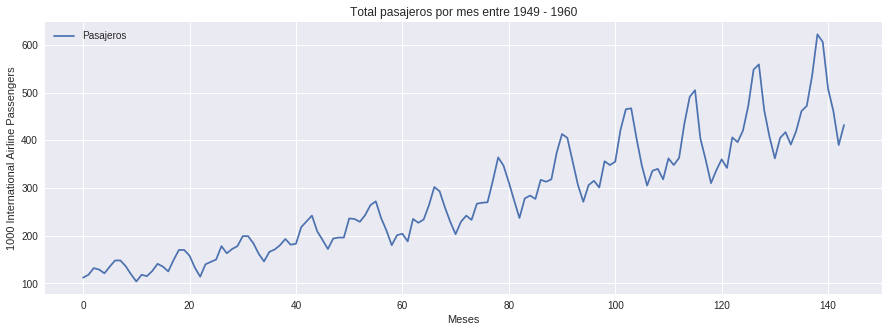

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(dataset, label = "Pasajeros")
plt.xlabel("Meses")
plt.ylabel("1000 International Airline Passengers")
plt.title("Total pasajeros por mes entre 1949 - 1960")
plt.legend()
plt.show()

**1.3-Codificar los datos**

En este caso los datos son numéricos con lo que sólo requieren procesamiento para escalarlos y normalizarlos:

* Se convierten todos los datos a tipo real (float32).
* Se realizar una escacla de los datos con MinMax, otra forma de normalización. Una ventaja es que se da estabilidad a los datos pero, un problema es que comprime los datos de entrada entre unos límites empíricos (el máximo y el mínimo de la variable). Esto quiere decir que si existe ruido, se va a ampliar.
* Se da nueva forma a los datos para disponer una tener como nombre "Y" en el código y otra como predictor ($X).



In [0]:
# Get the raw data values from the pandas data frame.
data_raw = dataset.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.01544401],
       [0.02702703],
       [0.05405405],
       [0.04826255],
       [0.03281853]], dtype=float32)

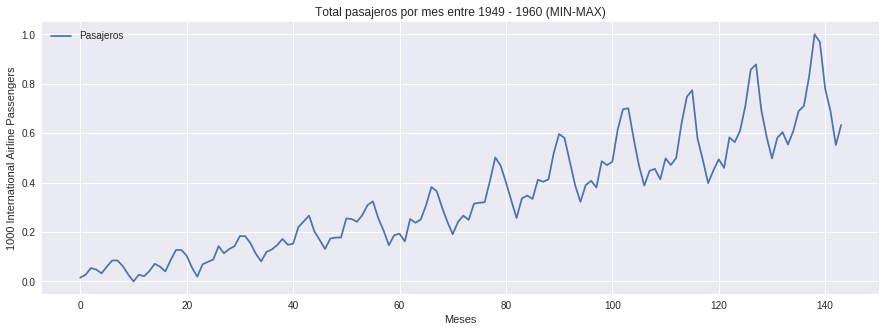

In [0]:
plt.figure(figsize = (15, 5))
plt.plot(dataset, label = "Pasajeros")
plt.xlabel("Meses")
plt.ylabel("1000 International Airline Passengers")
plt.title("Total pasajeros por mes entre 1949 - 1960 (MIN-MAX)")
plt.legend()
plt.show()

**1.4-Seleccionar los datos**

En este caso, los datos se separan en un 60% para entrenamiento y el resto para test.





In [0]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Número de instancias (training set, test set): " + str((len(train), len(test))))

Número de instancias (training set, test set): (86, 58)


A continuación, con esta función se crean subdatasets del tamaño requerido por el entrentamiento (ventana de tiempo igual a los n-1 valores).

In [0]:
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [0]:
#Un ejemplo de uso
data = np.array([[0.01544401], [0.02702703], [0.05405405]])
x, y = create_dataset(data,1)
print (x)
print (y)


In [0]:
a = np.zeros((10, 2))
print (a)
np.reshape(a, (5, 4)) 
print ("Reshape los elementos:")
print (a)

In [39]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(84, 1)
New training data shape:
(84, 1, 1)


## Paso 2: Arquitectura e implementación de nuestra red


1.   La entrada de nuestra red será una capa con 4 nodos de acuerdo a las dimensiones de nuestros datos.
2.  La función de activación en la capa de salida no se establece para que sea un número. 
4. La función de pérdida será  **mse**.
5. La función de optimización **adam**. 
6. Métricas: en este caso se selecciona sólo la precisión.



In [0]:
model = Sequential()
model.add(LSTM(4,input_shape = (1, window_size)))
model.add(Dropout(0.2))
model.add(Dense(1))



In [0]:
model.compile(loss = "mse", optimizer = "adam", metrics=['acc'])

## Paso 3:  Entrenamiento



En este caso el entrenamiento se realiza utilizando el 60% de los datos y el 40% para el test (validation_split)

In [44]:
history = model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    

Epoch 1/100
 - 2s - loss: 0.0412 - acc: 0.0119
Epoch 2/100
 - 0s - loss: 0.0206 - acc: 0.0119
Epoch 3/100
 - 0s - loss: 0.0158 - acc: 0.0119
Epoch 4/100
 - 0s - loss: 0.0137 - acc: 0.0119
Epoch 5/100
 - 0s - loss: 0.0133 - acc: 0.0119
Epoch 6/100
 - 0s - loss: 0.0123 - acc: 0.0119
Epoch 7/100
 - 0s - loss: 0.0121 - acc: 0.0119
Epoch 8/100
 - 0s - loss: 0.0110 - acc: 0.0119
Epoch 9/100
 - 0s - loss: 0.0103 - acc: 0.0119
Epoch 10/100
 - 0s - loss: 0.0108 - acc: 0.0119
Epoch 11/100
 - 0s - loss: 0.0095 - acc: 0.0119
Epoch 12/100
 - 0s - loss: 0.0094 - acc: 0.0119
Epoch 13/100
 - 0s - loss: 0.0086 - acc: 0.0119
Epoch 14/100
 - 0s - loss: 0.0093 - acc: 0.0119
Epoch 15/100
 - 0s - loss: 0.0088 - acc: 0.0119
Epoch 16/100
 - 0s - loss: 0.0094 - acc: 0.0119
Epoch 17/100
 - 0s - loss: 0.0074 - acc: 0.0119
Epoch 18/100
 - 0s - loss: 0.0073 - acc: 0.0119
Epoch 19/100
 - 0s - loss: 0.0067 - acc: 0.0119
Epoch 20/100
 - 0s - loss: 0.0062 - acc: 0.0119
Epoch 21/100
 - 0s - loss: 0.0052 - acc: 0.0119
E

In [45]:
print("Accuracy (entrenamiento):",history.history['acc'])

Accuracy (entrenamiento): [0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011904761904761904, 0.011

## Paso 4:  Test y Predicción

En este caso, se va a validar con el conjunto de test:


*   Se pasa como parámetro el modelo entrenado.
*   Se pasan los valores de entrada y los esperados de salida (X,Y)
*   Se calculan valores para los datos de entrenamiento y de test.
*   Se calcula RMSE (error cuadrático medio). Se busca penalizar tanto los valores por defecto como por exceso. El valor preferente es pequeño indicando que que los valores pronosticados están cerca de los valores observados. 




In [46]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 22.35 RMSE
Test data score: 53.72 RMSE


* Se estima mejor en entrenamiento que en test.
* Se muestra la pérdida por cada una de las iteraciones.

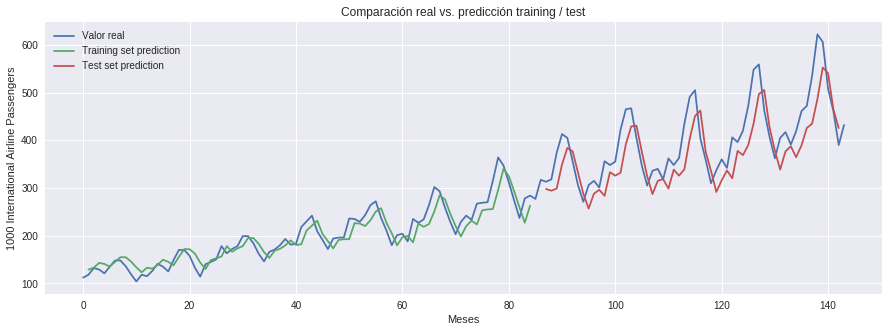

In [48]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (15, 5))
plt.plot(scaler.inverse_transform(dataset), label = "Valor real")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Meses")
plt.ylabel("1000 International Airline Passengers")
plt.title("Comparación real vs. predicción training / test")
plt.legend()
plt.show()

#Paso 6: Guardar configuración del modelo

In [0]:
network.save('/content/drive/My Drive/Colab Notebooks/models/ejemplo-9.h5')

#Tareas

1.   Cambiar el tamaño de la ventana (regresión múltiple).
2.   Eliminar la temporalidad de la serie, dejando sólo la tendencia.

> * https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/

3.   Cambiar la arquitectura de la red LSTM
4.   Discutir LSTM vs ARIMA. Ver esta [discusión](https://datascience.stackexchange.com/questions/12721/time-series-prediction-using-arima-vs-lstm).

> * https://arxiv.org/abs/1803.06386



#Otras referencias
* Paper en modelado de series temporales: https://arxiv.org/pdf/1705.09137.pdf
* Paper en modelado de series temporales: https://arxiv.org/pdf/1705.05690.pdf
* Curso de LSTM por Nando de Freitas: https://www.youtube.com/watch?v=56TYLaQN4N8
* https://www.slideshare.net/RalphSchlosser/lstm-tutorial
*  https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
*  https://towardsdatascience.com/using-lstms-to-forecast-time-series-4ab688386b1f
* https://github.com/kmsravindra/ML-AI-experiments/tree/master/AI/LSTM-time_series
